In [10]:
# https://github.com/matterport/Mask_RCNN    
import cv2 as cv2
import argparse
import numpy as np
import os.path
import sys
import random

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Initialize the parameters
confThreshold = 0.5  # Confidence threshold
maskThreshold = 0.3  # Mask threshold

In [51]:
# Draw the predicted bounding box, colorize and show the mask on the image

def drawBox(frame, classId, conf, left, top, right, bottom, classMask):
    
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)
    
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

    classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
    mask = (classMask > maskThreshold)
    roi = frame[top:bottom+1, left:right+1][mask]

    colorIndex = random.randint(0, len(colors)-1)
    color = colors[colorIndex]                 # mask 가중치    
    frame[top:bottom+1, left:right+1][mask] = ([0.7*color[0], 0.7*color[1], 0.7*color[2]] + 0.3 * roi).astype(np.uint8)

    
def postprocess(boxes, masks):
    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]

    frameH = frame.shape[0]
    frameW = frame.shape[1]

    for i in range(numDetections):
        box = boxes[0, 0, i]  # 7개 정보  ?, classid, score, left, top 
        mask = masks[i]
        score = box[2]
        if score > confThreshold:
            classId = int(box[1])
            # Extract the bounding box
            left = int(frameW * box[3])
            top = int(frameH * box[4])
            right = int(frameW * box[5])
            bottom = int(frameH * box[6])
            
            left = max(0, min(left, frameW - 1))
            top = max(0, min(top, frameH - 1))
            right = max(0, min(right, frameW - 1))
            bottom = max(0, min(bottom, frameH - 1))
            
            # Extract the mask for the object
            classMask = mask[classId]

            # Draw bounding box, colorize and show the mask on the image
            drawBox(frame, classId, score, left, top, right, bottom, classMask)



In [47]:
classesFile = "mscoco_labels.names";
classes = None
with open(classesFile, 'rt') as f:
   classes = f.read().rstrip('\n').split('\n')

textGraph = "mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"
modelWeights = "frozen_inference_graph.pb"   # 다운받아야 함

# Load the network
net = cv2.dnn.readNetFromTensorflow(modelWeights, textGraph)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

# Load the classes
colorsFile = "colors.txt";
with open(colorsFile, 'rt') as f:
    colorsStr = f.read().rstrip('\n').split('\n')
colors = [] #[0,0,0]
for i in range(len(colorsStr)):
    rgb = colorsStr[i].split(' ')
    color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
    colors.append(color)

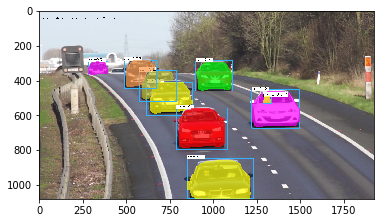

In [52]:
frame = cv2.imread('cars.jpg')

blob = cv2.dnn.blobFromImage(frame, swapRB=True, crop=False)
net.setInput(blob)

boxes, masks = net.forward(['detection_out_final', 'detection_masks'])

postprocess(boxes, masks)

t, _ = net.getPerfProfile()
label = 'Mask-RCNN, Inference time for a frame : %0.0f ms' % abs(t * 1000.0 / cv.getTickFrequency())
cv.putText(frame, label, (20, 45), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

cv.imwrite("output.jpg", frame) 
img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
plt.imshow(img)

(1, 1, 100, 7)
(100, 90, 15, 15)
[0.         2.         0.81254685 0.44311842 0.78289765 0.64019954
 1.        ]
2


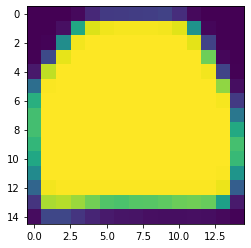

In [44]:
print(boxes.shape)   # 1,1,100box,7개 정보
print(masks.shape)   # 100개box, 90개클래스, mask

print(boxes[0,0,5])  # 5번째 box
id = int(boxes[0,0,5,1])
print(id)

m = masks[0,id, :,:]
plt.imshow(m)